# Glass Classification dataset

## Code

In [87]:
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from functools import partial
from sklearn import tree

## Sort data

In [88]:
#sort data
glass_data = pd.read_csv("./Glass Data/glass.data", names= ["ID Number", "Refractive Index", 
                                                             "Sodium", "Magnesium", "Aluminum",
                                                             "Silicon", "Potassium", "Calcium",
                                                              "Barium", "Iron", "Type of Glass"
                                                            ])
# drop ID Number, as it is not relevant.
glass_data = glass_data.drop(labels=["ID Number"],axis=1)
print(glass_data.shape)

#need to resort types of glass
#sorting through the original dataset, it is very unbalanced.
#were I to divide it into 0-4 as 1 (windowed glass), 5-7 as 0 (non-windowed glass), the count would be 163:51
print(glass_data['Type of Glass'].value_counts())
#to solve for this, the original dataset did label out float glass (1,3) vs non-float glasses (2,4); count is 87:76, more balanced.
#this will be what will be used for classification purposes.
glass_data = glass_data.loc[~((glass_data['Type of Glass'] == 5) | (glass_data['Type of Glass'] == 6) | (glass_data['Type of Glass'] == 7))]
print(glass_data['Type of Glass'].value_counts())

##finally, sort into float (1) or non-float (0)
glass_data['Type of Glass'] = glass_data['Type of Glass'].replace({1:1, 2:0, 3:1})

(214, 10)
Type of Glass
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64
Type of Glass
2    76
1    70
3    17
Name: count, dtype: int64


## What the data looks like after cleaning

In [89]:
print(glass_data['Type of Glass'].value_counts())
glass_data

Type of Glass
1    87
0    76
Name: count, dtype: int64


,Refractive Index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type of Glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...
158,1.51776,13.53,3.41,1.52,72.04,0.58,8.79,0.00,0.00,1
159,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.00,0.09,1
160,1.51832,13.33,3.34,1.54,72.14,0.56,8.99,0.00,0.00,1
161,1.51934,13.64,3.54,0.75,72.65,0.16,8.89,0.15,0.24,1


In [90]:
#get X,Y for sake of training later.
XY = glass_data.values
X = XY[:,:-1]
y = XY[:,-1]
XY.shape

#scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)


## Partition data sets, visualize dataset partitions for sanity check!

In [91]:
#Data partitions (0.8/0.2 training-data, 0.5/0.5 training-to-data, 0.2/0.8 training-to-data)


#80-20 split
Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#50-50 split
Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#20-80 split
Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [92]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == 0).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='non-float')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='float')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

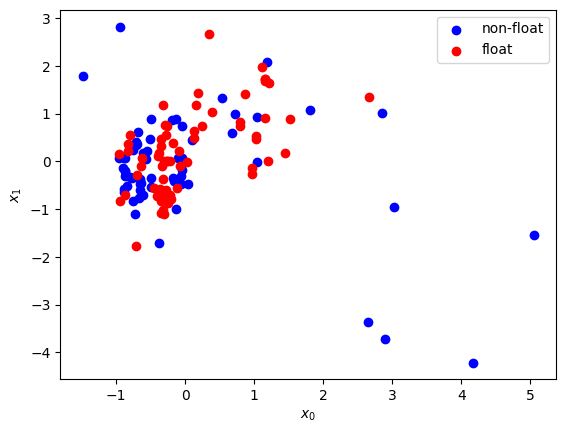

In [93]:
#more visualization
#Visualize training set as a sanity check; classes (0,1) are being plotted.
vis(Split1X_train, Split1y_train)

# Classifiers

## Partition: 80/20 set

Partition: 0.8
Train Accuracy: 0.9384615384615385
Validation Accuracy: 0.8461538461538461


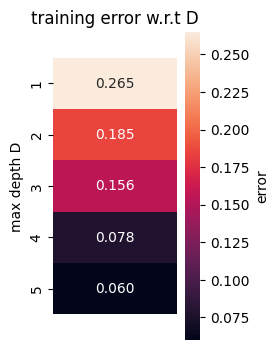

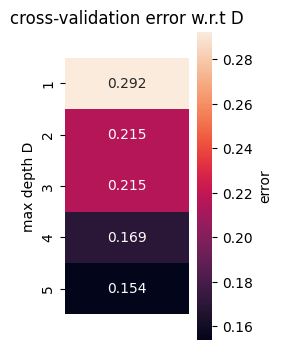

Best max depth D: 5
Test error: 0.24242424242424243
Train Accuracy: 0.9076923076923077
Validation Accuracy: 0.8076923076923077


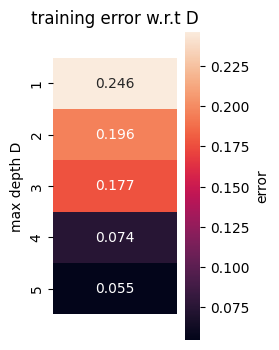

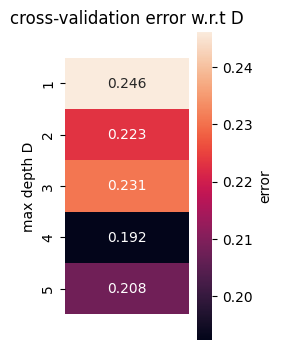

Best max depth D: 4
Test error: 0.18181818181818177
Train Accuracy: 0.9230769230769231
Validation Accuracy: 0.8


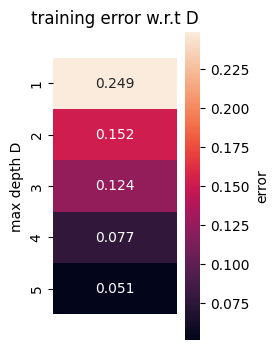

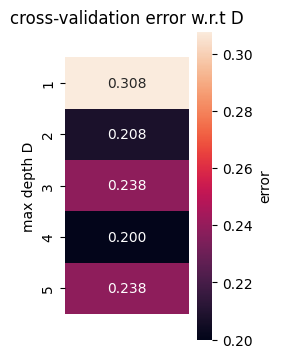

Best max depth D: 4
Test error: 0.3939393939393939


In [94]:
### Decision Tree ###
DTtestAccuracy_List1=[]
DTtestAccuracy_ListOverall = []
partitions = [0.8]
DTbest_max_depth_overall = 0
DT_best_accuracy = 0
trial = 3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        DTtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))


Partition: 0.8
Train Accuracy: 0.9769230769230769
Validation Accuracy: 0.8461538461538461


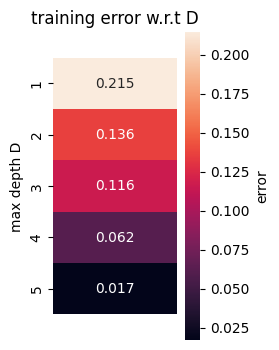

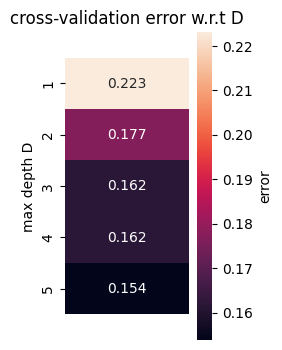

Best max depth D: 5
Test error: 0.1515151515151515
Train Accuracy: 0.8692307692307693
Validation Accuracy: 0.8384615384615385


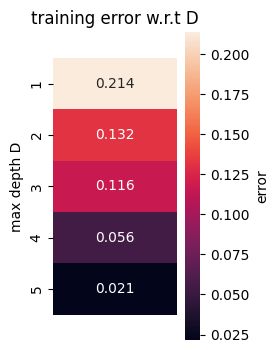

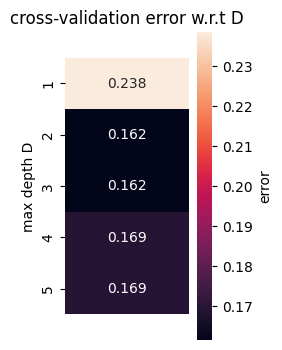

Best max depth D: 2
Test error: 0.2727272727272727
Train Accuracy: 0.9769230769230769
Validation Accuracy: 0.8846153846153847


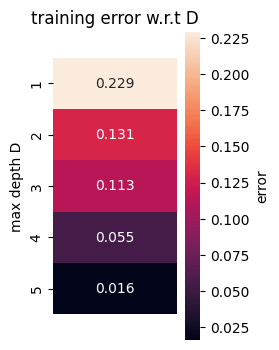

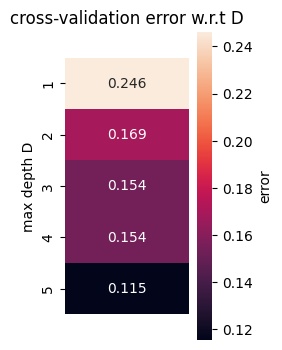

Best max depth D: 5
Test error: 0.21212121212121215


In [95]:
### Random Forests ###
RFtestAccuracy_List1=[]
RFtestAccuracy_ListOverall = []
partitions = [0.8]
RFbest_max_depth_overall = 0
RF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        RFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))
        

Partition: 0.8
Train Accuracy: 0.9846153846153847
Validation Accuracy: 0.8923076923076924


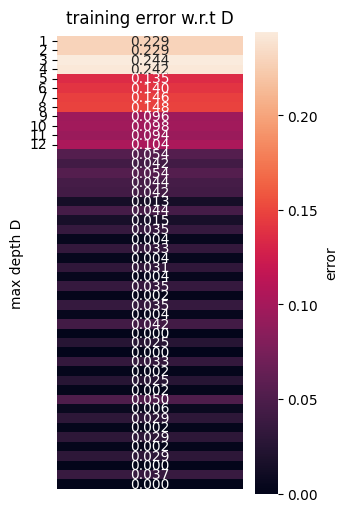

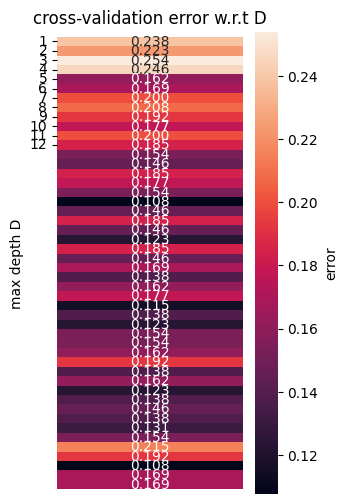

Best max depth D: 5
Test error: 0.12121212121212122
Train Accuracy: 1.0
Validation Accuracy: 0.876923076923077


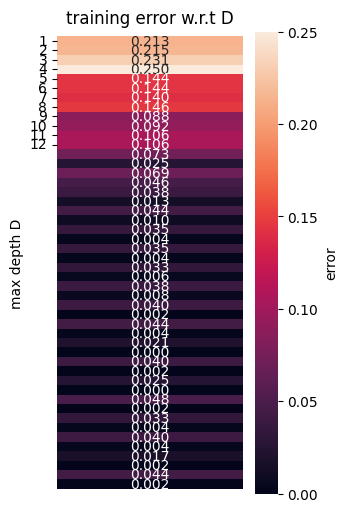

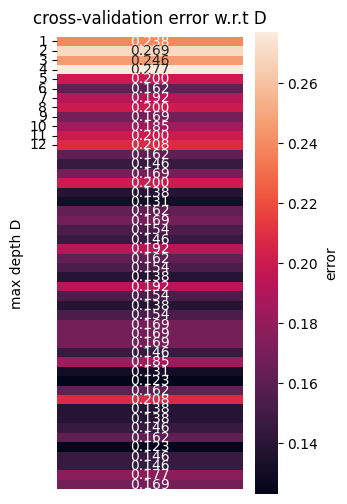

Best max depth D: 11
Test error: 0.21212121212121215
Train Accuracy: 0.9923076923076923
Validation Accuracy: 0.9


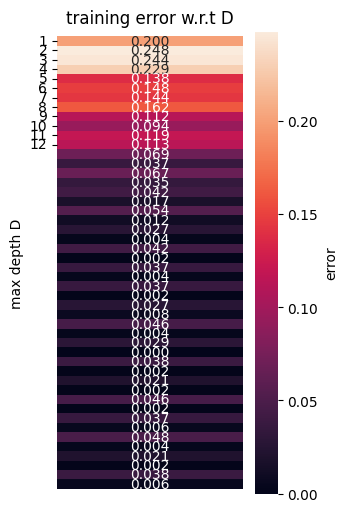

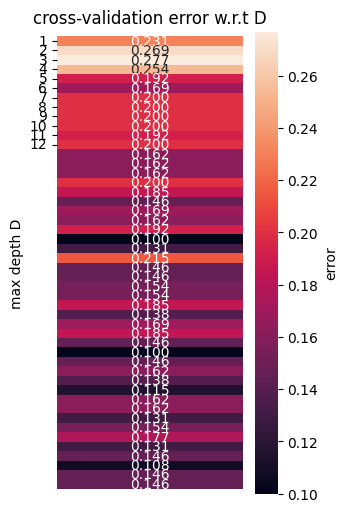

Best max depth D: 6
Test error: 0.21212121212121215


In [96]:
### Bagging family ###
BFtestAccuracy_List1=[]
BFtestAccuracy_ListOverall = []
partitions = [0.8]
BFbest_max_depth_overall = None
BF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split1X_train, Split1y_train)
        BFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))

Partition: 0.8
Best C: 10, Best Gamma: 0.1
Train Accuracy: 0.9076923076923077
Validation Accuracy: 0.8230769230769232


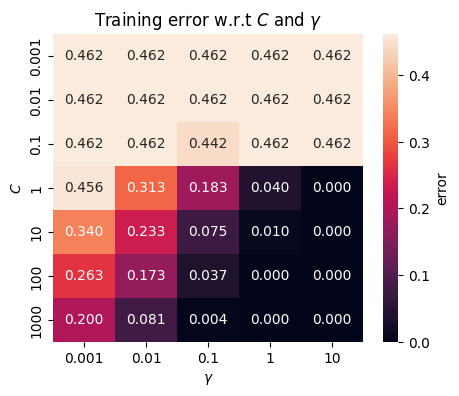

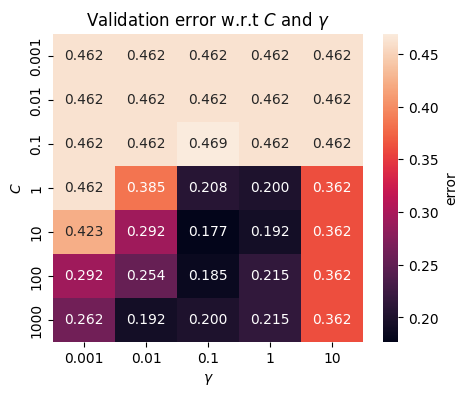

Best C: 1, Best Gamma: 0.1
Train Accuracy: 0.8384615384615385
Validation Accuracy: 0.776923076923077


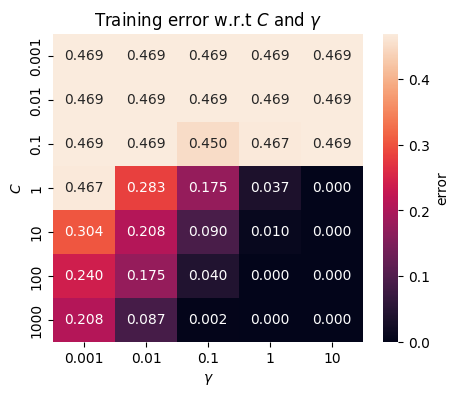

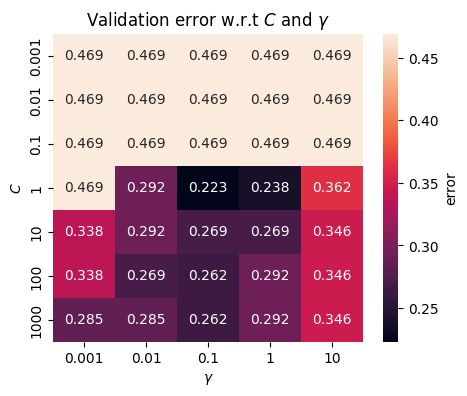

Best C: 1, Best Gamma: 1
Train Accuracy: 0.9692307692307692
Validation Accuracy: 0.8384615384615384


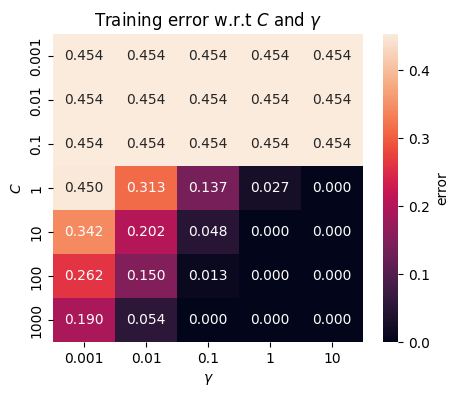

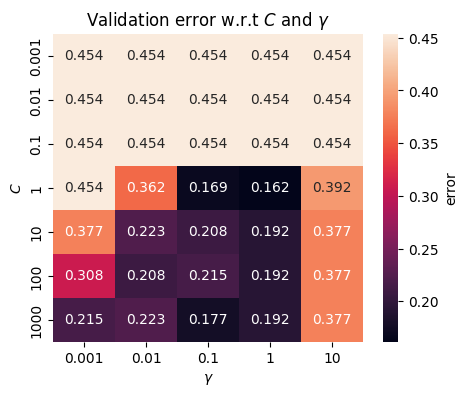

In [97]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.8]
trial = 3
testAccuracy_List1=[]
testAccuracy_ListOverall = []
training_errors = np.zeros((len(C_list), len(gamma_list)))
best_training_accuracy =0
best_C_overall = 0
best_gamma_overall = 0

#run 3 trials per partition
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split1X_train, Split1y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']


        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma


        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
    
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split1X_train, Split1y_train)
        testAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))




## Partition: 50/50 set

Partition: 0.5
Train Accuracy: 0.8148148148148148
Validation Accuracy: 0.788888888888889


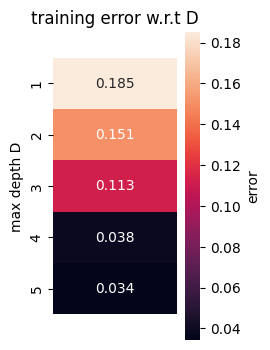

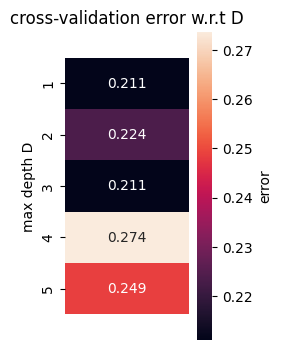

Best max depth D: 1
Test error: 0.31707317073170727
Train Accuracy: 0.7530864197530864
Validation Accuracy: 0.7180555555555556


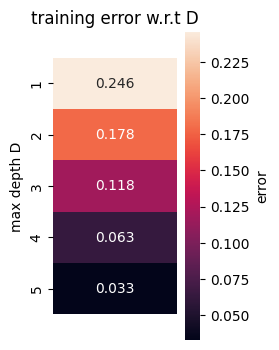

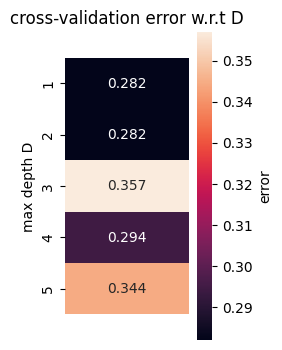

Best max depth D: 1
Test error: 0.25609756097560976
Train Accuracy: 0.9506172839506173
Validation Accuracy: 0.6430555555555555


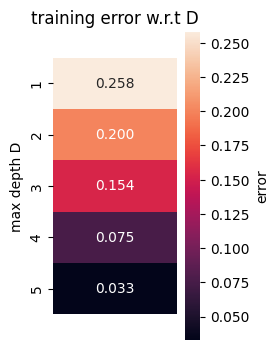

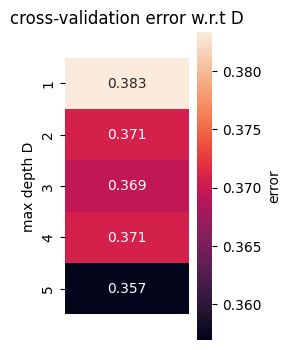

Best max depth D: 5
Test error: 0.25609756097560976


In [98]:
### Decision Tree ###
DTtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        DTtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Train Accuracy: 0.8765432098765432
Validation Accuracy: 0.8138888888888889


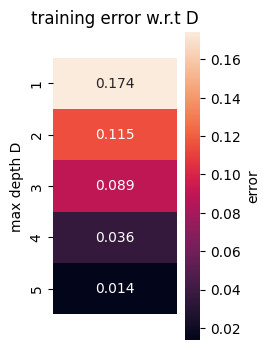

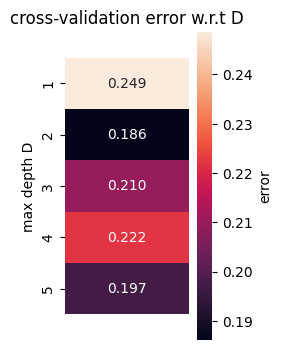

Best max depth D: 2
Test error: 0.2195121951219512
Train Accuracy: 0.9876543209876543
Validation Accuracy: 0.8638888888888889


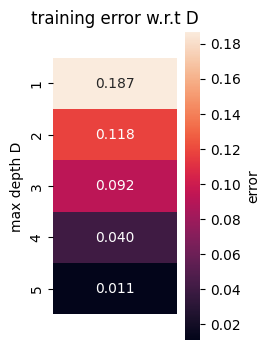

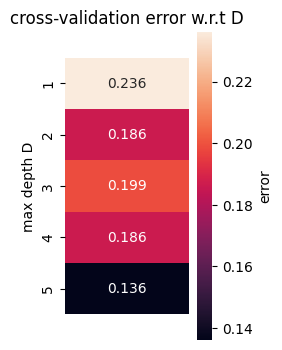

Best max depth D: 5
Test error: 0.13414634146341464
Train Accuracy: 0.8765432098765432
Validation Accuracy: 0.8013888888888889


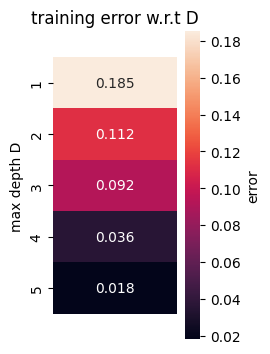

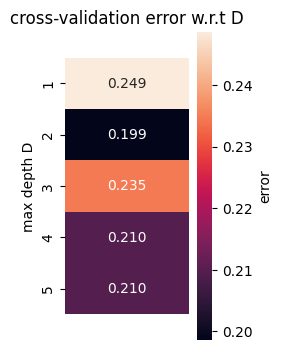

Best max depth D: 2
Test error: 0.23170731707317072


In [99]:
### Random Forests ###
RFtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        RFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))
        

Partition: 0.5
Train Accuracy: 0.9876543209876543
Validation Accuracy: 0.8764705882352942


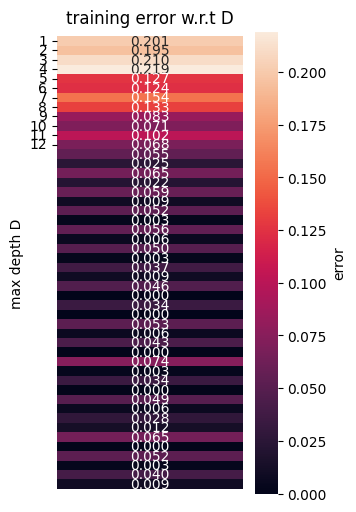

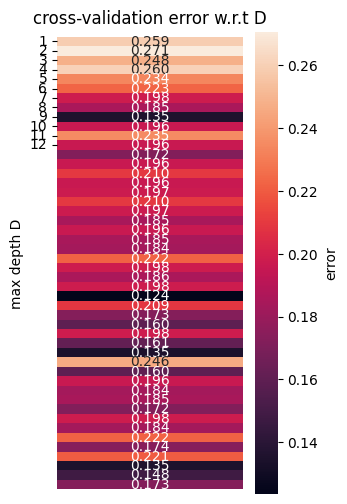

Best max depth D: 7
Test error: 0.20731707317073167
Train Accuracy: 1.0
Validation Accuracy: 0.8654411764705883


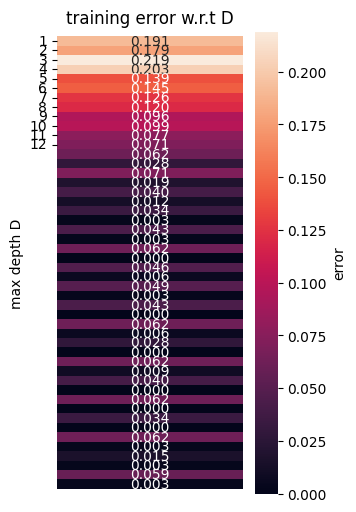

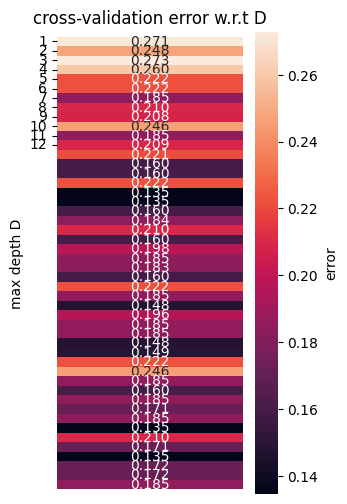

Best max depth D: 11
Test error: 0.09756097560975607
Train Accuracy: 1.0
Validation Accuracy: 0.8529411764705882


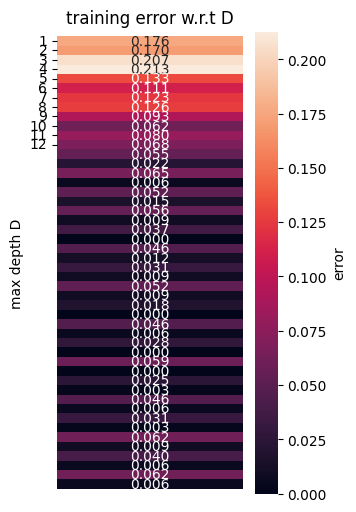

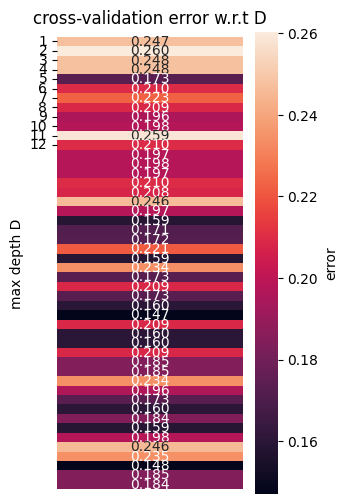

Best max depth D: 8
Test error: 0.1097560975609756


In [100]:
### Bagging family ###
BFtestAccuracy_List2=[]
partitions = [0.5]

for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Best C: 100, Best Gamma: 1
Train Accuracy: 1.0
Validation Accuracy: 0.8529411764705882


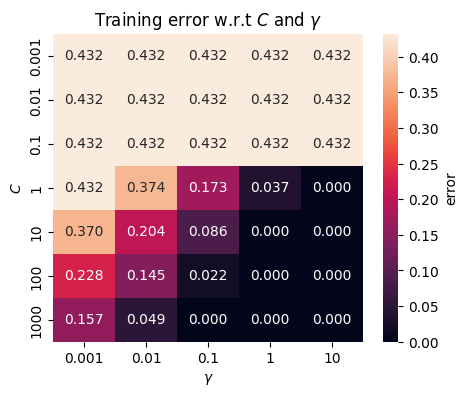

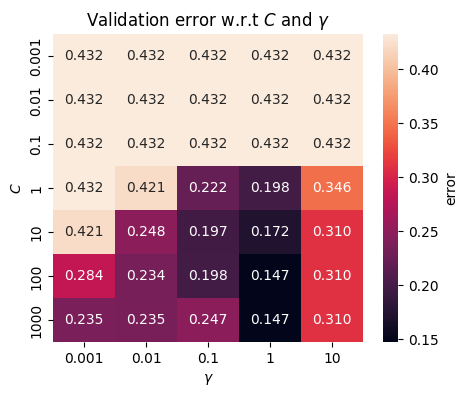

Best C: 1000, Best Gamma: 0.001
Train Accuracy: 0.8024691358024691
Validation Accuracy: 0.7676470588235295


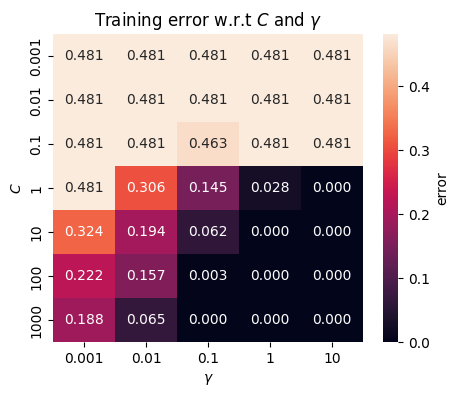

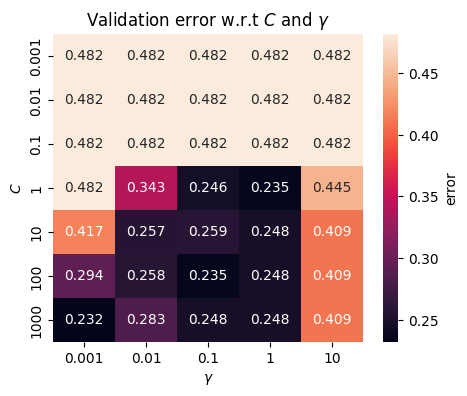

Best C: 10, Best Gamma: 0.1
Train Accuracy: 0.9506172839506173
Validation Accuracy: 0.7779411764705882


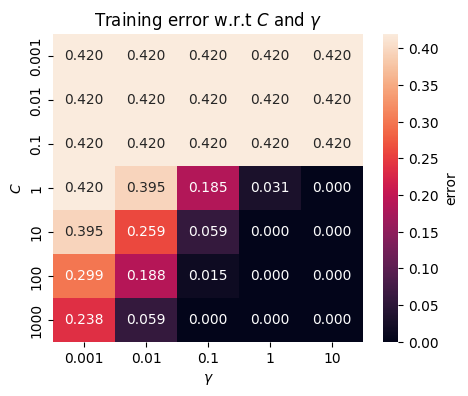

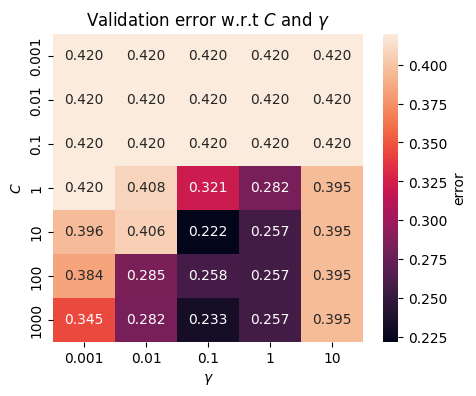

In [101]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.5]
trial = 3
testAccuracy_List2=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split2X_train, Split2y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")


        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        bestC= classifier_Search.best_params_['C']
        bestGamma= classifier_Search.best_params_['gamma']
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split2X_train, Split2y_train)
        testAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))


## Partition: 20/80 set

Partition: 0.2
Train Accuracy: 0.96875
Validation Accuracy: 0.8083333333333332


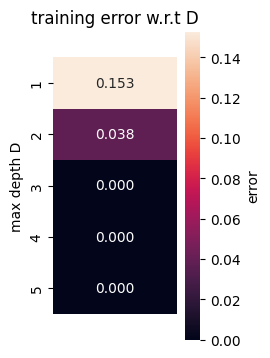

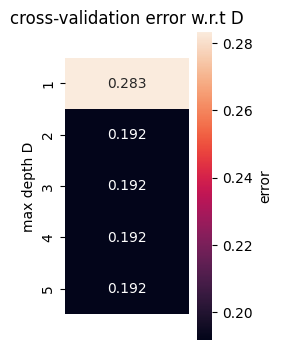

Best max depth D: 2
Test error: 0.20610687022900764
Train Accuracy: 0.75
Validation Accuracy: 0.6916666666666667


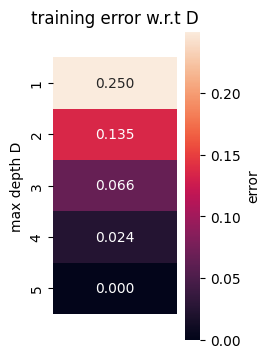

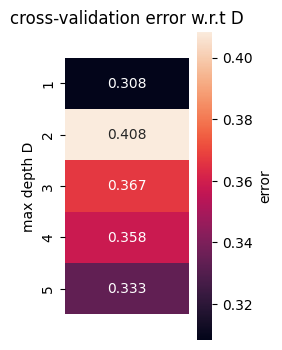

Best max depth D: 1
Test error: 0.33587786259541985
Train Accuracy: 0.96875
Validation Accuracy: 0.9333333333333332


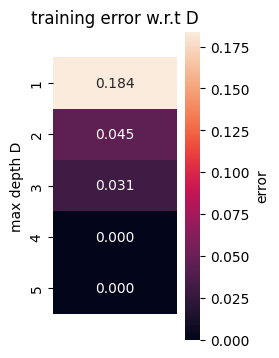

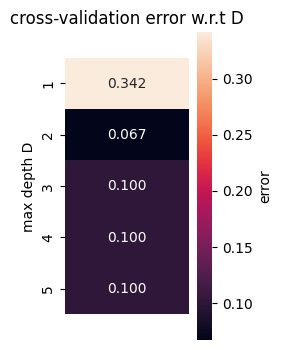

Best max depth D: 2
Test error: 0.3282442748091603


In [102]:
### Decision Tree ###
DTtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        DTtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Train Accuracy: 1.0
Validation Accuracy: 0.7833333333333333


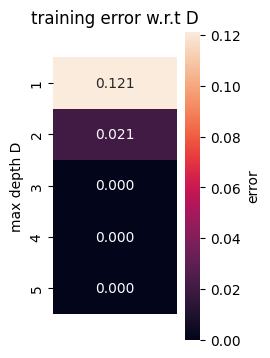

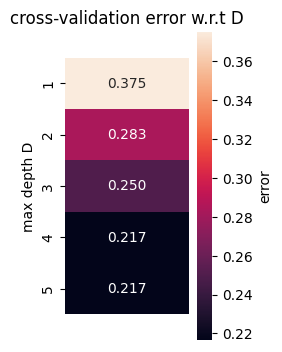

Best max depth D: 4
Test error: 0.18320610687022898
Train Accuracy: 1.0
Validation Accuracy: 0.7833333333333333


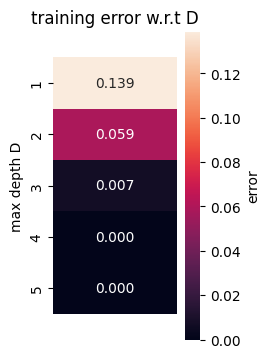

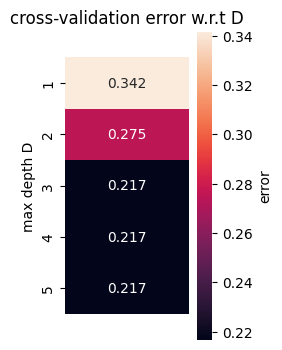

Best max depth D: 3
Test error: 0.18320610687022898
Train Accuracy: 1.0
Validation Accuracy: 0.75


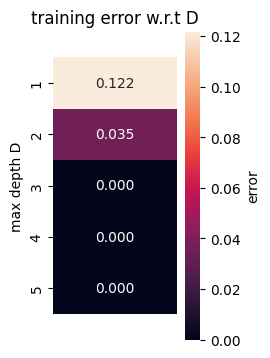

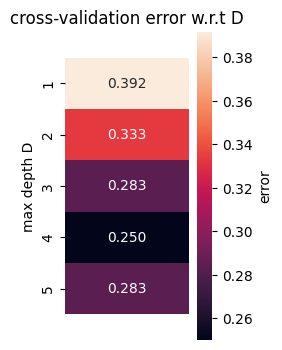

Best max depth D: 4
Test error: 0.16793893129770987


In [103]:
### Random Forests ###
RFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        RFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        

Partition: 0.2
Train Accuracy: 0.96875
Validation Accuracy: 0.7857142857142858


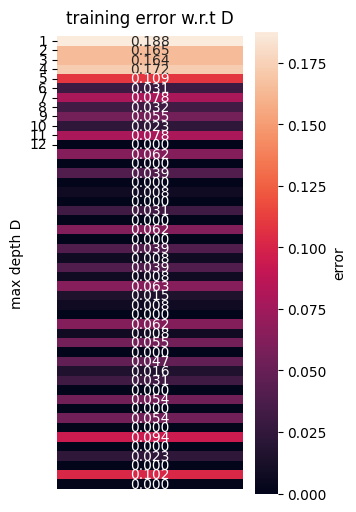

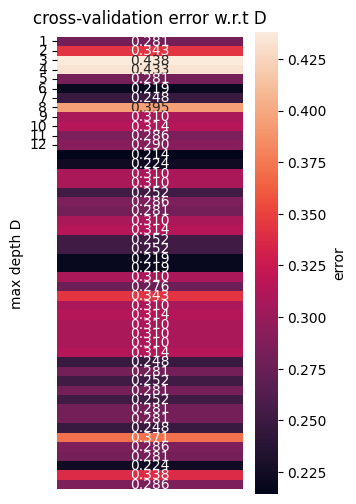

Best max depth D: 4
Test error: 0.32061068702290074
Train Accuracy: 1.0
Validation Accuracy: 0.8095238095238095


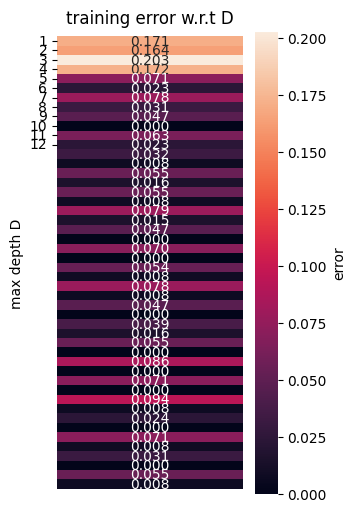

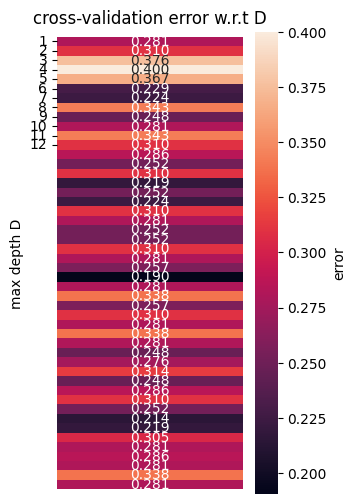

Best max depth D: 7
Test error: 0.2137404580152672
Train Accuracy: 0.96875
Validation Accuracy: 0.8428571428571429


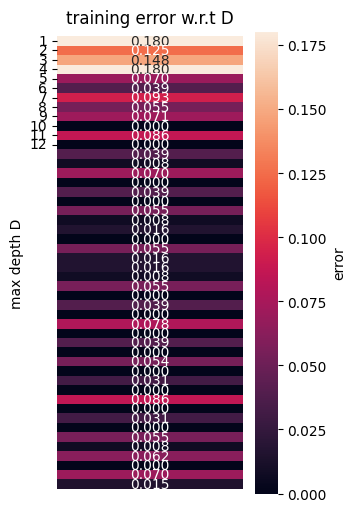

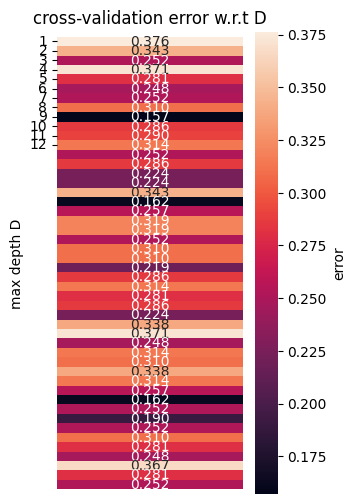

Best max depth D: 3
Test error: 0.19083969465648853


In [104]:
### Bagging family ###
BFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Best C: 1000, Best Gamma: 0.001
Train Accuracy: 0.875
Validation Accuracy: 0.7476190476190476


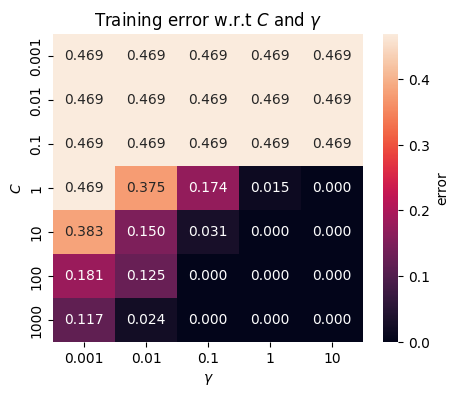

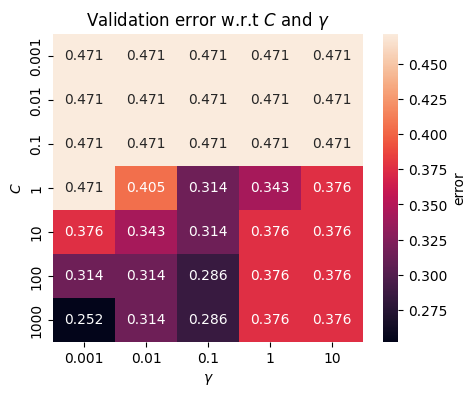

Best C: 10, Best Gamma: 10
Train Accuracy: 1.0
Validation Accuracy: 0.680952380952381


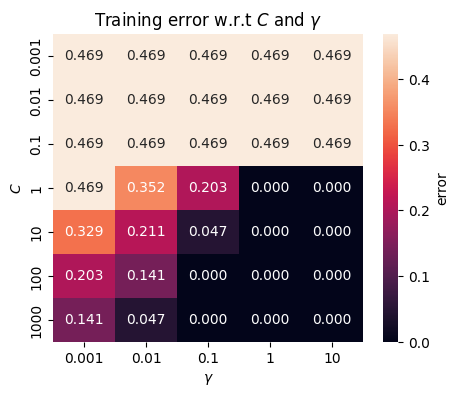

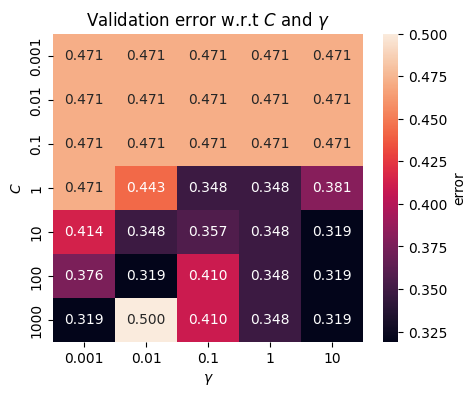

Best C: 100, Best Gamma: 0.1
Train Accuracy: 1.0
Validation Accuracy: 0.9047619047619048


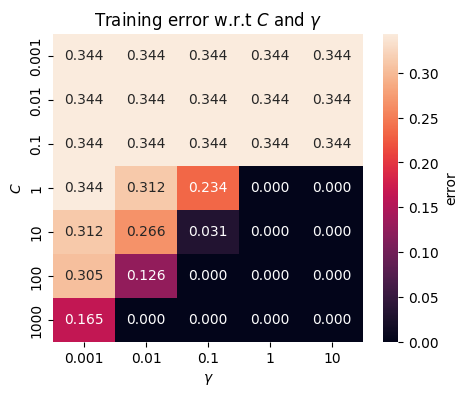

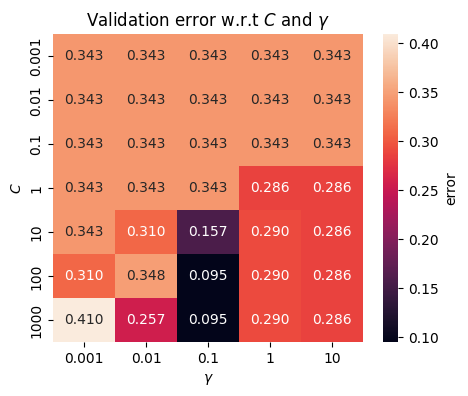

In [105]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.2]
trial = 3
testAccuracy_List3=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split3X_train, Split3y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = classifier_Search.best_score_


        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split3X_train, Split3y_train)
        testAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        testAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))


## Best training accuracy with optimal Hyperparameter

In [106]:
### Report best training accuracies with their optimal hyperparameters. ###
print(f'Best training accuracy for Decision Tree: {DT_best_accuracy} with optimal hyperparameter D:{DTbest_max_depth_overall}.')
print(f'Best training accuracy for Random Forests: {RF_best_accuracy} with optimal hyperparameter D:{RFbest_max_depth_overall}.')
print(f'Best training accuracy for Bagging family: {BF_best_accuracy} with optimal hyperparameter D:{BFbest_max_depth_overall}.')
print(f'Best training accuracy for SVM w/RBF: {best_training_accuracy} with optimal hyperparameter C:{best_C_overall} and gamma:{best_gamma_overall}')

Best training accuracy for Decision Tree: 0.96875 with optimal hyperparameter D:2.
Best training accuracy for Random Forests: 1.0 with optimal hyperparameter D:4.
Best training accuracy for Bagging family: 1.0 with optimal hyperparameter D:11.
Best training accuracy for SVM w/RBF: 1.0 with optimal hyperparameter C:100 and gamma:1


## Report test data respective average accuracy.

In [114]:
### Decision Tree ###
print(f'The average of the test accuracies for Decision Tree is: {sum(DTtestAccuracy_ListOverall) / len(DTtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for  80/20 split Decision Tree is: {sum(DTtestAccuracy_List1) / len(DTtestAccuracy_List1)}')
print(f'The average of the test accuracies for  50/50 split Decision Tree is: {sum(DTtestAccuracy_List2) / len(DTtestAccuracy_List2)}')
print(f'The average of the test accuracies for  20/80 split Decision Tree is: {sum(DTtestAccuracy_List3) / len(DTtestAccuracy_List3)}')

The average of the test accuracies for Decision Tree is: 0.7287973134184268
The average of the test accuracies for  80/20 split Decision Tree is: 0.7777777777777777
The average of the test accuracies for  50/50 split Decision Tree is: 0.6910569105691057
The average of the test accuracies for  20/80 split Decision Tree is: 0.7175572519083969


In [123]:
### Random Forests ###
print(f'The average of the test accuracies for Random Forests is: {sum(RFtestAccuracy_ListOverall) / len(RFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Random Forests is: {sum(RFtestAccuracy_List1) / len(RFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Random Forests is: {sum(RFtestAccuracy_List2) / len(RFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Random Forests is: {sum(RFtestAccuracy_List3) / len(RFtestAccuracy_List3)}')

The average of the test accuracies for Random Forests is: 0.8151464373769345
The average of the test accuracies for 80/20 Random Forests is: 0.8181818181818182
The average of the test accuracies for 50/50 Random Forests is: 0.8130081300813009
The average of the test accuracies for 20/80 Random Forests is: 0.8142493638676845


In [109]:
### Bagging family ### 
print(f'The average of the test accuracies for Bagging family is: {sum(BFtestAccuracy_ListOverall) / len(BFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Bagging family is: {sum(BFtestAccuracy_List1) / len(BFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Bagging family is: {sum(BFtestAccuracy_List2) / len(BFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Bagging family is: {sum(BFtestAccuracy_List3) / len(BFtestAccuracy_List3)}')

The average of the test accuracies for Bagging family is: 0.8718354023697535
The average of the test accuracies for 80/20 Bagging family is: 0.8686868686868686
The average of the test accuracies for 50/50 Bagging family is: 0.8333333333333334
The average of the test accuracies for 20/80 Bagging family is: 0.9134860050890584


In [112]:
### SVM w/RBF kernel ###
print(f'The average of the test accuracies for SVM w/RBF is: {sum(testAccuracy_ListOverall) / len(testAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 split SVM w/RBF is: {sum(testAccuracy_List1) / len(testAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 split SVM w/RBF is: {sum(testAccuracy_List2) / len(testAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 split SVM w/RBF is: {sum(testAccuracy_List3) / len(testAccuracy_List3)}')

The average of the test accuracies for SVM w/RBF is: 0.7131157663646959
The average of the test accuracies for 80/20 split SVM w/RBF is: 0.7373737373737373
The average of the test accuracies for 50/50 split SVM w/RBF is: 0.7073170731707318
The average of the test accuracies for 20/80 split SVM w/RBF is: 0.6946564885496183
